In [1]:
import pandas as pd
import sqlite3
import geopandas as gps
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from pandas import read_csv
from pygris import block_groups
import contextily as cx
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import numpy as np
import matplotlib

warnings.filterwarnings("ignore")

data_path = '/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/BEAM-CORE/Lab call/PSRC/'
os.chdir(data_path)

In [2]:
# load land use data - base year 2018
psrc_crs = 'EPSG:2285'

baseline_parcel_path = 'v3.0.0_2018_2050/landuse/2018/v3.0_RTP/parcels_urbansim.txt'
psrc_parcels = pd.read_csv(baseline_parcel_path, sep = ' ')

# load PSRC parcel geography
parcel_geography = pd.read_csv('SoundCast_processed/parcel_2018_geography.csv')
print(len(parcel_geography))
print(parcel_geography.columns)

soundcast_input_db = 'v3.0.0_2018_2050/db/soundcast_inputs.db'
db_con = sqlite3.connect(soundcast_input_db)

psrc_parcels.head(5)

1302434
Index(['field1', 'ParcelID', 'rg_proposed', 'CityName', 'Census2010Block',
       'Census2010BlockGroup', 'Census2010Tract', 'minority_geog',
       'poverty_geog', 'GrowthCenterName', 'FAZID', 'taz_p', 'parcel_id_x',
       'District', 'district_name', 'CountyName', 'TAZ', 'LowIncome',
       'PeopleofColor', 'BaseYear', 'GEOID10', 'place_name', 'parcel_id_y',
       'disability_geog_vs_50_percent', 'disability_geog_vs_reg_total',
       'elderly_geog_vs_50_percent', 'elderly_geog_vs_reg_total',
       'english_geog_vs_50_percent', 'english_geog_vs_reg_total',
       'poverty_geog_vs_50_percent', 'poverty_geog_vs_reg_total',
       'racial_geog_vs_50_percent', 'racial_geog_vs_reg_total',
       'youth_geog_vs_50_percent', 'youth_geog_vs_reg_total'],
      dtype='object')


aparks  empedu_p  empfoo_p  empgov_p  empind_p  empmed_p  empofc_p  \
0       0         0         0         0         0         0         0   
1       0         0         0         0         0         0         0   
2       0         0         0         0         0         0         0   
3       0         0         0         0         5         2        17   
4       0         0         0         0         0         0         0   

   empoth_p  empret_p  emprsc_p  ...  ppricdyp  pprichrp  sfunits  sqft_p  \
0         0         0         0  ...         0         0        0   60440   
1         0         0         0  ...         0         0        0    5446   
2         0         0         0  ...         0         0        1    3438   
3         9         6         0  ...         0         0        0    5112   
4         0         0         0  ...         0         0        0    6068   

   stugrd_p  stuhgh_p  stuuni_p  taz_p      xcoord_p       ycoord_p  
0         0         0         0   1019  1.292251e+06  162729.949912  
1         0         0         0   1018  1.291828e+06  164043.167618  
2         0         0         0   1018  1.291590e+06  164050.082322  
3         0         0         0   1018  1.291535e+06  164051.591361  
4         0         0         0   1018  1.291475e+06  164043.810513  

[5 rows x 29 columns]

In [3]:
forecast_parcel_path = \
'v3.0.0_2018_2050/landuse/2050/rtp_2050_updated_income/parcels_urbansim.txt'
psrc_parcels_2050 = pd.read_csv(forecast_parcel_path, sep = ' ')
print(len(psrc_parcels_2050))
psrc_parcels_2050.head(5)

1302434


aparks  empedu_p  empfoo_p  empgov_p  empind_p  empmed_p  empofc_p  \
0       0         0         0         0         0         0         0   
1       0         0         0         0         0         0         0   
2       0         0         2         0         0         0         0   
3       0         0         0         0         4         3        18   
4       0         0         0         0         0         0         0   

   empoth_p  empret_p  emprsc_p  ...  ppricdyp  pprichrp  sfunits  sqft_p  \
0         0         0         0  ...         0         0        0   60440   
1         0         0         0  ...         0         0        0    5446   
2         0         2         0  ...         0         0        1    3438   
3         8         5         0  ...         0         0        0    5112   
4         0         0         0  ...         0         0        0    6068   

   stugrd_p  stuhgh_p  stuuni_p  taz_p      xcoord_p       ycoord_p  
0         0         0         0   1019  1.292251e+06  162729.949912  
1         0         0         0   1018  1.291828e+06  164043.167618  
2         0         0         0   1018  1.291590e+06  164050.082322  
3         0         0         0   1018  1.291535e+06  164051.591361  
4         0         0         0   1018  1.291475e+06  164043.810513  

[5 rows x 29 columns]

In [4]:
# load LEHD data
lehd_file = 'WA_naics_2018.csv'
lehd_validation = read_csv(os.path.join('BEAM', lehd_file))
print(lehd_validation.columns)
lehd_validation.head(5)

# assign SoundCast sector
lehd_sectors = ['LEHD_Other', 'LEHD_Industrial', 'LEHD_Retail', 'LEHD_Office',
                'LEHD_Education', 'LEHD_Medical', 'LEHD_Service', 'LEHD_Government']
lehd_validation.loc[:, 'LEHD_Other'] = lehd_validation.loc[:, 'n11'] + \
lehd_validation.loc[:, 'n21'] + lehd_validation.loc[:, 'n23']

lehd_validation.loc[:, 'LEHD_Industrial'] = lehd_validation.loc[:, 'n3133'] + \
lehd_validation.loc[:, 'n22'] + lehd_validation.loc[:, 'n42'] + \
lehd_validation.loc[:, 'n4849']

lehd_validation.loc[:, 'LEHD_Retail'] = lehd_validation.loc[:, 'n4445']

lehd_validation.loc[:, 'LEHD_Office'] = lehd_validation.loc[:, 'n51'] + \
lehd_validation.loc[:, 'n52'] + lehd_validation.loc[:, 'n53'] + \
lehd_validation.loc[:, 'n54'] + lehd_validation.loc[:, 'n55'] + \
lehd_validation.loc[:, 'n56']

lehd_validation.loc[:, 'LEHD_Education'] = lehd_validation.loc[:, 'n61']

lehd_validation.loc[:, 'LEHD_Medical'] = lehd_validation.loc[:, 'n62']

lehd_validation.loc[:, 'LEHD_Service'] = lehd_validation.loc[:, 'n71'] + \
lehd_validation.loc[:, 'n72'] + lehd_validation.loc[:, 'n81']

lehd_validation.loc[:, 'LEHD_Government'] = lehd_validation.loc[:, 'n92']

lehd_validation = lehd_validation.set_index('GEOID')
lehd_validation = lehd_validation[lehd_sectors]
lehd_validation.loc[:, 'LEHD_Total'] = lehd_validation[lehd_sectors].sum(axis = 1)
lehd_validation.head(5)
# lehd_validation.loc[:, 'Other'] = lehd_validation.loc[:, 'n11'] + \
# lehd_validation.loc[:, 'n21'] + lehd_validation.loc[:, 'n23']

Index(['GEOID', 'metalayer_id', 'n11', 'n21', 'n22', 'n23', 'n3133', 'n42',
       'n4445', 'n4849', 'n51', 'n52', 'n53', 'n54', 'n55', 'n56', 'n61',
       'n62', 'n71', 'n72', 'n81', 'n92'],
      dtype='object')


LEHD_Other  LEHD_Industrial  LEHD_Retail  LEHD_Office  \
GEOID                                                                 
530019501001          31               11            4            5   
530019501002          11                9           27            7   
530019501003           0               60           56           49   
530019502001          15                2            8            0   
530019502002           8               15            9            1   

              LEHD_Education  LEHD_Medical  LEHD_Service  LEHD_Government  \
GEOID                                                                       
530019501001               0             0             1                0   
530019501002              86           111           137                1   
530019501003              11            10            40              255   
530019502001              33             0             2                4   
530019502002              61             1             3               22   

              LEHD_Total  
GEOID                     
530019501001          52  
530019501002         389  
530019501003         481  
530019502001          64  
530019502002         120

In [4]:
# load SynthFirm data
synthfirm_emp_file = 'emp_by_zone_industry.geojson'
synthfirm_emp = gps.read_file(os.path.join('BEAM', synthfirm_emp_file))
synthfirm_firm_file = 'firms_by_zone_industry.geojson'
synthfirm_firm = gps.read_file(os.path.join('BEAM', synthfirm_firm_file))
print(synthfirm_emp.columns)
# synthfirm_firm.head(5)
synthfirm_firm_df = pd.DataFrame(synthfirm_firm.drop(columns='geometry'))
synthfirm_emp_df = pd.DataFrame(synthfirm_emp.drop(columns='geometry'))
synthfirm_emp_df.head(5)

Index(['GEOID', 'CBPZONE', 'MESOZONE', 'area', '11', '21', '22', '23', '31',
       '32', '33', '42', '44', '45', '48', '49', '4A', '51', '52', '53', '54',
       '55', '56', '61', '62', '71', '72', '81', 'S0', 'total', 'geometry'],
      dtype='object')


GEOID  CBPZONE  MESOZONE       area          11   21        22  \
0  530559601001    53055    3312.0  64.302680    9.000000  0.0  4.404377   
1  530330293053    53033    1923.0   0.891907    0.000000  0.0  0.000000   
2  530330205002    53033    1429.0   0.435125    0.000000  0.0  0.000000   
3  530770028021    53077    4720.0  11.053392  476.460996  0.0  0.000000   
4  530530620003    53053    2850.0   0.291052    0.000000  0.0  0.000000   

          23         31         32  ...          54   55          56  \
0  92.782436   0.000000   0.000000  ...   17.377778  0.0   13.389717   
1   8.760612   0.000000  27.159742  ...   22.101335  0.0   32.253642   
2   8.576502  47.439209   3.136103  ...  745.637374  0.0    0.000000   
3  24.119663   0.000000   0.000000  ...    0.000000  0.0    5.734763   
4   0.000000   0.000000   0.000000  ...    0.000000  0.0  190.962737   

          61          62        71          72         81   S0        total  
0  12.828815   11.600000  2.000000  228.678012  55.026190  0.0   491.919675  
1   0.000000   34.953511  0.000000    0.000000   0.000000  0.0   127.170243  
2   8.993782  159.899356  0.000000   20.703023  12.567329  0.0  1147.825635  
3   2.000000   15.201474  5.090909  154.716134  16.778047  0.0   700.101987  
4   0.000000    8.840538  0.000000   69.017234   0.000000  0.0   268.820510  

[5 rows x 30 columns]

In [5]:
synthfirm_sectors = ['SynthFirm_Other', 'SynthFirm_Industrial', 
                     'SynthFirm_Retail', 'SynthFirm_Office',
                     'SynthFirm_Education', 'SynthFirm_Medical', 
                     'SynthFirm_Service', 'SynthFirm_Government']
synthfirm_firm_df.loc[:, 'SynthFirm_Other'] = synthfirm_firm_df.loc[:, '11'] + \
synthfirm_firm_df.loc[:, '21'] + synthfirm_firm_df.loc[:, '23']

synthfirm_firm_df.loc[:, 'SynthFirm_Industrial'] = \
synthfirm_firm_df.loc[:, '31']+ synthfirm_firm_df.loc[:, '32'] + \
synthfirm_firm_df.loc[:, '33'] + synthfirm_firm_df.loc[:, '22'] + \
synthfirm_firm_df.loc[:, '42'] + synthfirm_firm_df.loc[:, '48'] + \
synthfirm_firm_df.loc[:, '49']

synthfirm_firm_df.loc[:, 'SynthFirm_Retail'] = synthfirm_firm_df.loc[:, '44'] + \
synthfirm_firm_df.loc[:, '45'] + synthfirm_firm_df.loc[:, '4A']

synthfirm_firm_df.loc[:, 'SynthFirm_Office'] = synthfirm_firm_df.loc[:, '51'] + \
synthfirm_firm_df.loc[:, '52'] + synthfirm_firm_df.loc[:, '53'] + \
synthfirm_firm_df.loc[:, '54'] + synthfirm_firm_df.loc[:, '55'] + \
synthfirm_firm_df.loc[:, '56']

synthfirm_firm_df.loc[:, 'SynthFirm_Education'] = synthfirm_firm_df.loc[:, '61']

synthfirm_firm_df.loc[:, 'SynthFirm_Medical'] = synthfirm_firm_df.loc[:, '62']

synthfirm_firm_df.loc[:, 'SynthFirm_Service'] = synthfirm_firm_df.loc[:, '71'] + \
synthfirm_firm_df.loc[:, '72'] + synthfirm_firm_df.loc[:, '81']

synthfirm_firm_df.loc[:, 'SynthFirm_Government'] = synthfirm_firm_df.loc[:, 'S0']

synthfirm_firm_df = synthfirm_firm_df.set_index('GEOID')
synthfirm_firm_df = synthfirm_firm_df[synthfirm_sectors]
synthfirm_firm_df.loc[:, 'SynthFirm_Total'] = synthfirm_firm_df[synthfirm_sectors].sum(axis = 1)
synthfirm_firm_df.head(5)

SynthFirm_Other  SynthFirm_Industrial  SynthFirm_Retail  \
GEOID                                                                   
530559601001             39.0                  11.0              11.0   
530330293053              3.0                   1.0               0.0   
530330205002              2.0                   4.0              13.0   
530770028021             33.0                   0.0               0.0   
530530620003              0.0                   0.0               0.0   

              SynthFirm_Office  SynthFirm_Education  SynthFirm_Medical  \
GEOID                                                                    
530559601001              22.0                  3.0                2.0   
530330293053              13.0                  0.0                5.0   
530330205002               5.0                  2.0               14.0   
530770028021               2.0                  2.0                2.0   
530530620003               2.0                  0.0                1.0   

              SynthFirm_Service  SynthFirm_Government  SynthFirm_Total  
GEOID                                                                   
530559601001               36.0                   0.0            124.0  
530330293053                0.0                   0.0             22.0  
530330205002                6.0                   0.0             46.0  
530770028021               17.0                   0.0             56.0  
530530620003                6.0                   0.0              9.0

In [6]:
synthfirm_emp_df.loc[:, 'SynthFirm_Other'] = synthfirm_emp_df.loc[:, '11'] + \
synthfirm_emp_df.loc[:, '21'] + synthfirm_emp_df.loc[:, '23']

synthfirm_emp_df.loc[:, 'SynthFirm_Industrial'] = \
synthfirm_emp_df.loc[:, '31']+ synthfirm_emp_df.loc[:, '32'] + \
synthfirm_emp_df.loc[:, '33'] + synthfirm_emp_df.loc[:, '22'] + \
synthfirm_emp_df.loc[:, '42'] + synthfirm_emp_df.loc[:, '48'] + \
synthfirm_emp_df.loc[:, '49']

synthfirm_emp_df.loc[:, 'SynthFirm_Retail'] = synthfirm_emp_df.loc[:, '44'] + \
synthfirm_emp_df.loc[:, '45'] + synthfirm_emp_df.loc[:, '4A']

synthfirm_emp_df.loc[:, 'SynthFirm_Office'] = synthfirm_emp_df.loc[:, '51'] + \
synthfirm_emp_df.loc[:, '52'] + synthfirm_emp_df.loc[:, '53'] + \
synthfirm_emp_df.loc[:, '54'] + synthfirm_emp_df.loc[:, '55'] + \
synthfirm_emp_df.loc[:, '56']

synthfirm_emp_df.loc[:, 'SynthFirm_Education'] = synthfirm_emp_df.loc[:, '61']

synthfirm_emp_df.loc[:, 'SynthFirm_Medical'] = synthfirm_emp_df.loc[:, '62']

synthfirm_emp_df.loc[:, 'SynthFirm_Service'] = synthfirm_emp_df.loc[:, '71'] + \
synthfirm_emp_df.loc[:, '72'] + synthfirm_emp_df.loc[:, '81']

synthfirm_emp_df.loc[:, 'SynthFirm_Government'] = synthfirm_emp_df.loc[:, 'S0']

synthfirm_emp_df = synthfirm_emp_df.set_index('GEOID')
synthfirm_emp_df = synthfirm_emp_df[synthfirm_sectors]
synthfirm_emp_df.loc[:, 'SynthFirm_Total'] = synthfirm_emp_df[synthfirm_sectors].sum(axis = 1)
synthfirm_emp_df.head(5)

SynthFirm_Other  SynthFirm_Industrial  SynthFirm_Retail  \
GEOID                                                                   
530559601001       101.782436             21.028432         16.974961   
530330293053         8.760612             27.159742          0.000000   
530330205002         8.576502             57.409904        131.000386   
530770028021       500.580659              0.000000          0.000000   
530530620003         0.000000              0.000000          0.000000   

              SynthFirm_Office  SynthFirm_Education  SynthFirm_Medical  \
GEOID                                                                    
530559601001         42.000828            12.828815          11.600000   
530330293053         56.296379             0.000000          34.953511   
530330205002        748.675355             8.993782         159.899356   
530770028021          5.734763             2.000000          15.201474   
530530620003        190.962737             0.000000           8.840538   

              SynthFirm_Service  SynthFirm_Government  SynthFirm_Total  
GEOID                                                                   
530559601001         285.704202                   0.0       491.919675  
530330293053           0.000000                   0.0       127.170243  
530330205002          33.270351                   0.0      1147.825635  
530770028021         176.585090                   0.0       700.101987  
530530620003          69.017234                   0.0       268.820510

In [5]:
state = 'WA'
analysis_year = 2018
region_cbg_map = \
gps.read_file('SoundCast_processed/tl_2018_53_bg/tl_2018_53_bg.shp')
# region_cbg_map = block_groups(state = state, year = analysis_year)
# # region_cbg_map.head(5)
region_cbg_map = region_cbg_map[['GEOID', 'ALAND', 'geometry']]
region_cbg_map.loc[:, 'GEOID'] = \
region_cbg_map.loc[:, 'GEOID'].astype(str).str.zfill(12)

# region_cbg_map = region_cbg_map.merge(pop_by_cbg,
#                                       on = 'GEOID',
#                                       how = 'inner')
print(len(region_cbg_map))
region_cbg_map.head(5)

4783


GEOID    ALAND                                           geometry
0  530610518023  1847888  POLYGON ((-122.28188 47.84291, -122.28146 47.8...
1  530379754022   478478  POLYGON ((-120.54449 46.98468, -120.54448 46.9...
2  530379754024   506935  POLYGON ((-120.53973 47.00194, -120.53967 47.0...
3  530379754025  1247379  POLYGON ((-120.53694 46.99157, -120.53655 46.9...
4  530379755002   717605  POLYGON ((-120.55036 47.00668, -120.55035 47.0...

In [6]:
parcel_geography_short = \
parcel_geography[['ParcelID','CityName', 'Census2010Block',
       'Census2010BlockGroup', 'Census2010Tract', 'FAZID', 'taz_p', 
                  'District', 'district_name', 'CountyName', 'TAZ', 
                  'BaseYear', 'GEOID10', 'place_name']]

parcel_geography_short.loc[:, 'Census2010BlockGroup'] = \
parcel_geography_short.loc[:, 'Census2010BlockGroup'].astype(int).astype(str).str.zfill(12)
parcel_geography_short.loc[:, 'State'] = \
parcel_geography_short.loc[:, 'Census2010BlockGroup'].str[0:2] 
parcel_geography_short.loc[:, 'County'] = \
parcel_geography_short.loc[:, 'Census2010BlockGroup'].str[2:5]
parcel_geography_short.loc[:, 'FIPS'] = \
parcel_geography_short.loc[:, 'Census2010BlockGroup'].str[0:5] 

parcel_geography_short.head(5)

ParcelID CityName  Census2010Block Census2010BlockGroup  Census2010Tract  \
0         1     Kent     5.303303e+14         530330292061     5.303303e+10   
1         2     Kent     5.303303e+14         530330292061     5.303303e+10   
2         3     Kent     5.303303e+14         530330292061     5.303303e+10   
3         4     Kent     5.303303e+14         530330292061     5.303303e+10   
4         5     Kent     5.303303e+14         530330292061     5.303303e+10   

   FAZID  taz_p  District       district_name CountyName   TAZ  BaseYear  \
0   3600   1019       7.0  Renton-FedWay-Kent       King  1019      2018   
1   3600   1018       7.0  Renton-FedWay-Kent       King  1018      2018   
2   3600   1018       7.0  Renton-FedWay-Kent       King  1018      2018   
3   3600   1018       7.0  Renton-FedWay-Kent       King  1018      2018   
4   3600   1018       7.0  Renton-FedWay-Kent       King  1018      2018   

        GEOID10 place_name State County   FIPS  
0  5.303303e+14       Kent    53    033  53033  
1  5.303303e+14       Kent    53    033  53033  
2  5.303303e+14       Kent    53    033  53033  
3  5.303303e+14       Kent    53    033  53033  
4  5.303303e+14       Kent    53    033  53033

In [7]:
print(len(psrc_parcels))
psrc_parcels = pd.merge(psrc_parcels,
                        parcel_geography_short,
                        left_on = ['parcelid', 'taz_p'],
                        right_on = ['ParcelID', 'taz_p'],
                        how = 'left')
print(len(psrc_parcels))

psrc_parcels_2050 = pd.merge(psrc_parcels_2050,
                        parcel_geography_short,
                        left_on = ['parcelid', 'taz_p'],
                        right_on = ['ParcelID', 'taz_p'],
                        how = 'left')
print(len(psrc_parcels_2050))

1302434
1302434
1302434


In [14]:
psrc_parcels.to_csv('SoundCast_processed/parcel_data_with_geography.csv',
                   index = False)

psrc_parcels_2050.to_csv('SoundCast_processed/parcel_data_with_geography_2050.csv',
                   index = False)
psrc_parcels.head(5)

aparks  empedu_p  empfoo_p  empgov_p  empind_p  empmed_p  empofc_p  \
0       0         0         0         0         0         0         0   
1       0         0         0         0         0         0         0   
2       0         0         0         0         0         0         0   
3       0         0         0         0         5         2        17   
4       0         0         0         0         0         0         0   

   empoth_p  empret_p  emprsc_p  ...  District       district_name  \
0         0         0         0  ...       7.0  Renton-FedWay-Kent   
1         0         0         0  ...       7.0  Renton-FedWay-Kent   
2         0         0         0  ...       7.0  Renton-FedWay-Kent   
3         9         6         0  ...       7.0  Renton-FedWay-Kent   
4         0         0         0  ...       7.0  Renton-FedWay-Kent   

   CountyName   TAZ  BaseYear       GEOID10  place_name  State  County   FIPS  
0        King  1019      2018  5.303303e+14        Kent     53     033  53033  
1        King  1018      2018  5.303303e+14        Kent     53     033  53033  
2        King  1018      2018  5.303303e+14        Kent     53     033  53033  
3        King  1018      2018  5.303303e+14        Kent     53     033  53033  
4        King  1018      2018  5.303303e+14        Kent     53     033  53033  

[5 rows x 45 columns]

In [8]:
psrc_parcels_job_only = psrc_parcels.loc[psrc_parcels['emptot_p'] > 0]
print(len(psrc_parcels_job_only))
psrc_parcels_job_only.to_csv('SoundCast_processed/parcel_data_with_geography_job_only.csv',
                   index = False)

psrc_parcels_2050_job_only = psrc_parcels_2050.loc[psrc_parcels_2050['emptot_p'] > 0]
print(len(psrc_parcels_2050_job_only))
psrc_parcels_2050_job_only.to_csv('SoundCast_processed/parcel_data_2050_job_only.csv',
                   index = False)


48171
62991


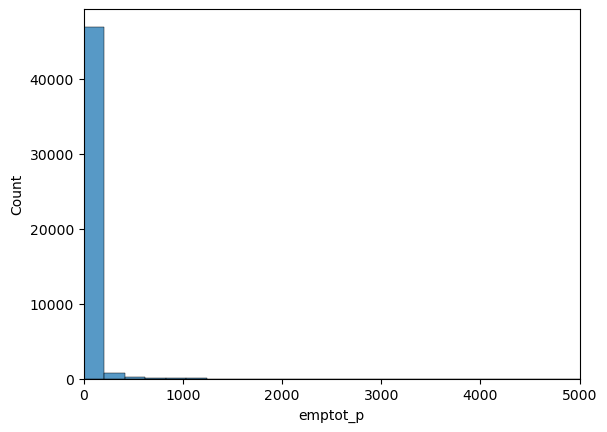

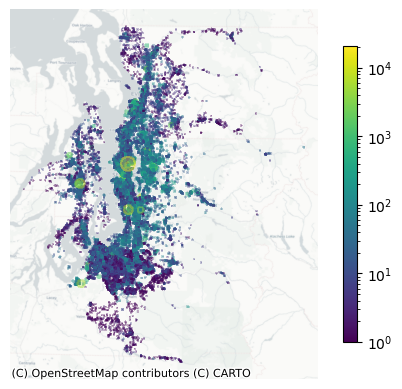

In [9]:
# create shapefile of parcel
# plot baseline employment at parcel level
sns.histplot(psrc_parcels_job_only, x = 'emptot_p', bins = 100)
plt.xlim([0, 5000])
plt.show()
psrc_parcels_job_only_gdf = gps.GeoDataFrame(
    psrc_parcels_job_only, 
    geometry=gps.points_from_xy(psrc_parcels_job_only.xcoord_p, 
                                psrc_parcels_job_only.ycoord_p), crs=psrc_crs)

ax = psrc_parcels_job_only_gdf.plot(column = 'emptot_p',
                               cmap='viridis',
                               alpha = 0.3, 
                               markersize = 0.005 * psrc_parcels_job_only_gdf['emptot_p'],
                               vmin = 0, vmax =1000,
                               legend=True,
                               norm=matplotlib.colors.LogNorm(vmin=1, 
                                                              vmax = psrc_parcels_job_only_gdf['emptot_p'].max()),
                               legend_kwds = {'shrink': 0.8}, antialiased=False)
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron, crs = psrc_crs)
plt.axis('off')
plt.savefig('plot/parcel_level_emp.png', dpi = 300, bbox_inches = 'tight')
plt.show()

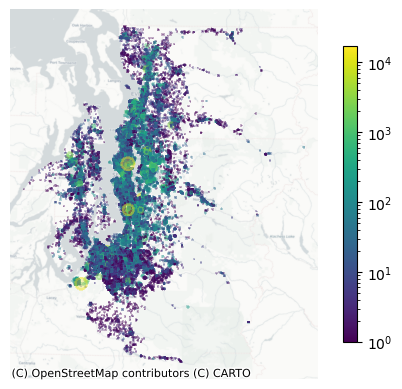

In [10]:
# plot 2050
psrc_parcels_2050_job_only_gdf = gps.GeoDataFrame(
    psrc_parcels_2050_job_only, 
    geometry=gps.points_from_xy(psrc_parcels_2050_job_only.xcoord_p, 
                                psrc_parcels_2050_job_only.ycoord_p), crs=psrc_crs)
psrc_parcels_2050_job_only_gdf.columns
ax = psrc_parcels_2050_job_only_gdf.plot(column = 'emptot_p',
                               cmap='viridis',
                               alpha = 0.3, 
                               markersize = 0.005 * psrc_parcels_2050_job_only['emptot_p'],
                               vmin = 0, vmax =1000,
                               legend=True,
                               norm=matplotlib.colors.LogNorm(vmin=1, 
                                                              vmax = psrc_parcels_2050_job_only['emptot_p'].max()),
                               legend_kwds = {'shrink': 0.8}, antialiased=False)
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron, crs = psrc_crs)
plt.axis('off')
plt.savefig('plot/parcel_level_emp_2050.png', dpi = 300, bbox_inches = 'tight')
plt.show()

Education


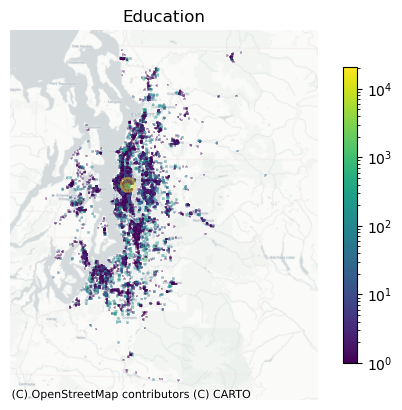

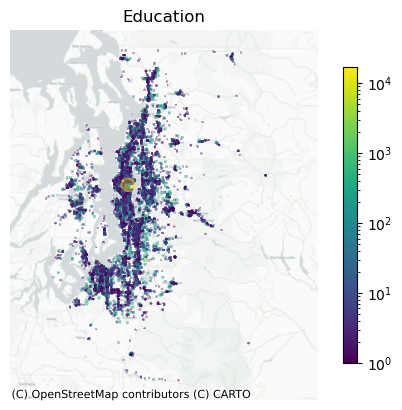

Government


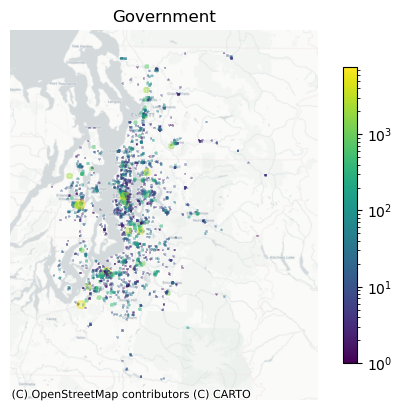

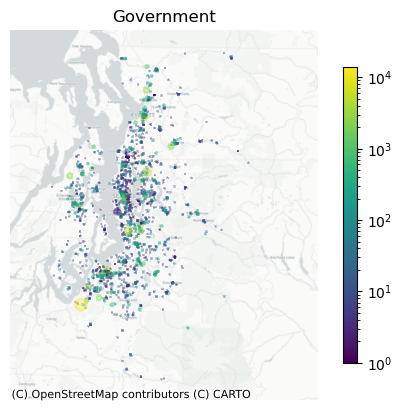

Industrial


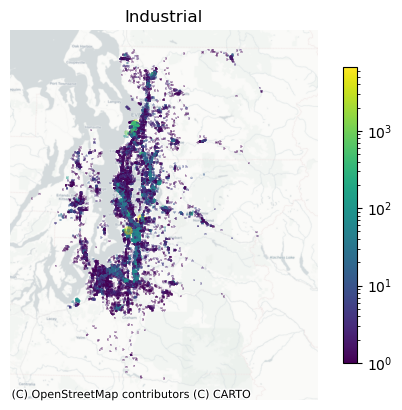

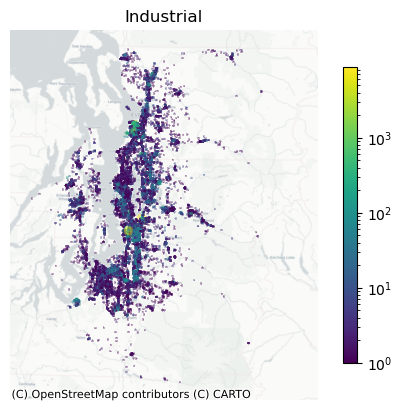

Medical


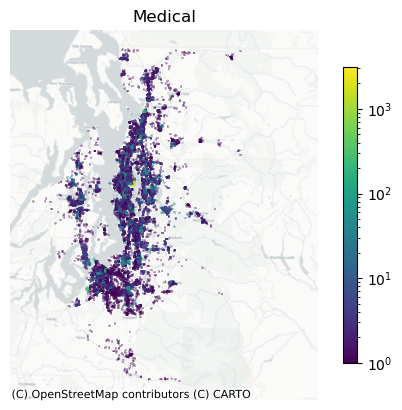

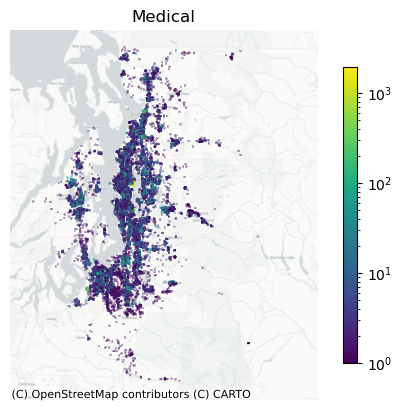

Other


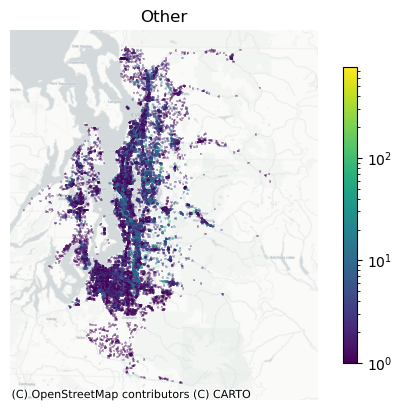

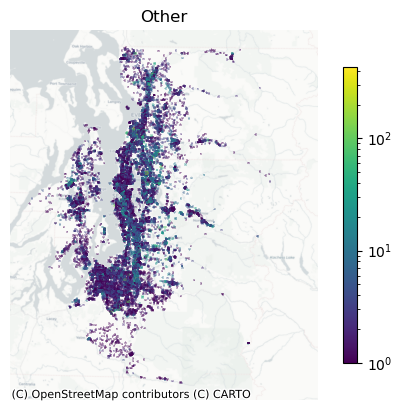

Retail


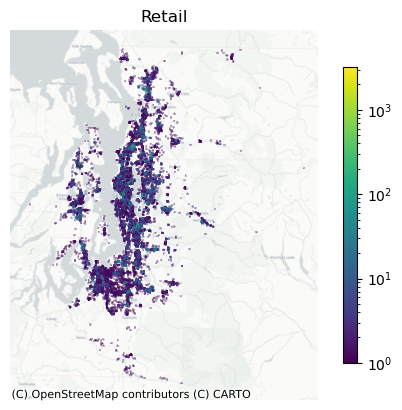

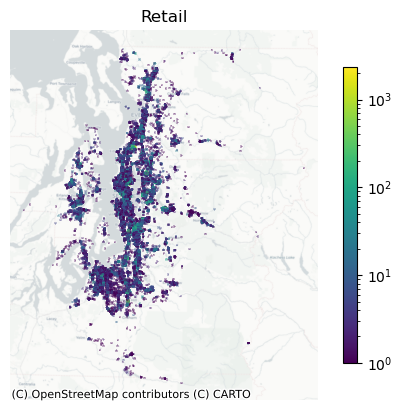

Office


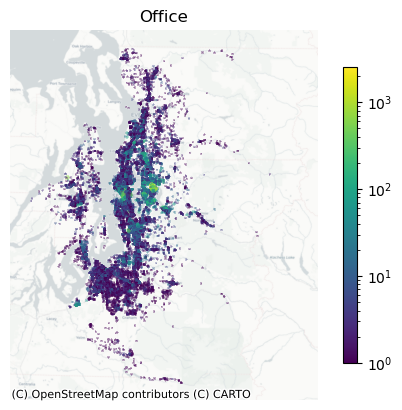

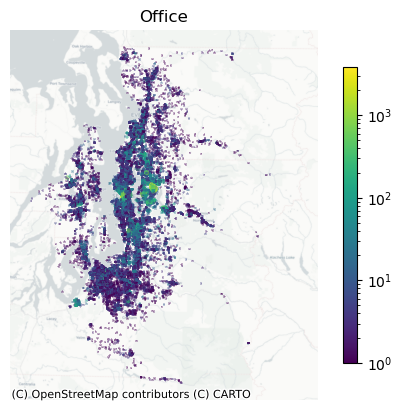

Service


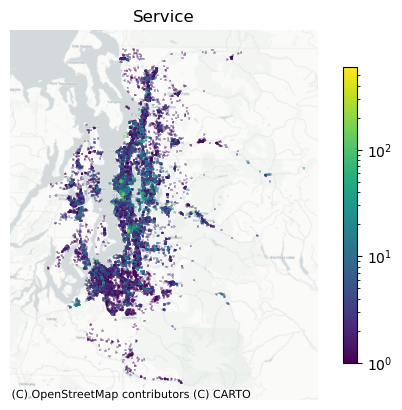

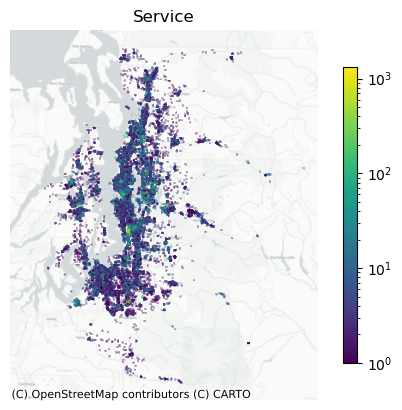

In [11]:
industry_attr = ['empedu_p', 'empfoo_p', 'empgov_p', 'empind_p', 'empmed_p',
       'empofc_p', 'empoth_p', 'empret_p', 'empsvc_p'] # 'emprsc_p'

psrc_sector = ['PSRC_Education', 'PSRC_Government', 'PSRC_Industrial', 'PSRC_Medical',
              'PSRC_Other', 'PSRC_Retail', 'PSRC_Office', 'PSRC_Service']
# psrc_emp_by_cbg.loc[:, 'GEOID'] = \
# psrc_emp_by_cbg.loc[:, 'Census2010BlockGroup'].astype(float).astype(int)
def emp_processor(df):
    df.loc[:, 'PSRC_Education'] = df.loc[:, 'empedu_p']
    df.loc[:, 'PSRC_Government'] = df.loc[:, 'empgov_p']
    df.loc[:, 'PSRC_Industrial'] = df.loc[:, 'empind_p']
    df.loc[:, 'PSRC_Medical'] = df.loc[:, 'empmed_p']
    df.loc[:, 'PSRC_Other'] = df.loc[:, 'empoth_p']
    df.loc[:, 'PSRC_Retail'] = df.loc[:, 'empret_p']
    df.loc[:, 'PSRC_Office'] = df.loc[:, 'empofc_p']
    df.loc[:, 'PSRC_Service'] = df.loc[:, 'empfoo_p'] + \
    df.loc[:, 'empsvc_p']
    return df 

psrc_parcels_job_only_gdf = \
emp_processor(psrc_parcels_job_only_gdf)

psrc_parcels_2050_job_only_gdf = \
emp_processor(psrc_parcels_2050_job_only_gdf)

for ind in psrc_sector: 
    ind_code = ind.split('_')[1]
    print(ind_code)

    # plot 2018
    ax = psrc_parcels_job_only_gdf.plot(column = ind,
                               cmap='viridis',
                               alpha = 0.3, 
                               markersize = 0.005 * psrc_parcels_job_only_gdf[ind],
                               vmin = 0, vmax =1000,
                               legend=True,
                               norm=matplotlib.colors.LogNorm(vmin=1, 
                                                              vmax = psrc_parcels_job_only_gdf[ind].max()),
                               legend_kwds = {'shrink': 0.8}, antialiased=False)
    cx.add_basemap(ax, source = cx.providers.CartoDB.Positron, crs = psrc_crs)
    plt.title(ind_code)
    plt.axis('off')
    plt.savefig('plot/parcel_level_' + ind_code + '.png', dpi = 300, bbox_inches = 'tight')
    plt.show()
    # plot 2050
    ax = psrc_parcels_2050_job_only_gdf.plot(column = ind,
                               cmap='viridis',
                               alpha = 0.3, 
                               markersize = 0.005 * psrc_parcels_2050_job_only_gdf[ind],
                               vmin = 0, vmax =1000,
                               legend=True,
                               norm=matplotlib.colors.LogNorm(vmin=1, 
                                                              vmax = psrc_parcels_2050_job_only_gdf[ind].max()),
                               legend_kwds = {'shrink': 0.8}, antialiased=False)
    cx.add_basemap(ax, source = cx.providers.CartoDB.Positron, crs = psrc_crs)
    plt.title(ind_code)
    plt.axis('off')
    plt.savefig('plot/parcel_level_' + ind_code + '_2050.png', dpi = 300, bbox_inches = 'tight')
    plt.show()

In [12]:
# PSRC employment data by cbg
# print(psrc_parcels.columns)
emp_attr = ['empedu_p', 'empfoo_p', 'empgov_p', 'empind_p', 'empmed_p',
       'empofc_p', 'empoth_p', 'empret_p', 'empsvc_p', 'emptot_p']
agg_var = ['CountyName', 'Census2010BlockGroup', 'BaseYear']
psrc_emp_by_cbg = psrc_parcels.groupby(agg_var)[emp_attr].sum()
psrc_emp_by_cbg = psrc_emp_by_cbg.reset_index()

psrc_emp_by_cbg_2050 = psrc_parcels_2050.groupby(agg_var)[emp_attr].sum()
psrc_emp_by_cbg_2050 = psrc_emp_by_cbg_2050.reset_index()

print(len(psrc_emp_by_cbg))
print(psrc_emp_by_cbg.emptot_p.sum())
print(len(psrc_emp_by_cbg_2050))
print(psrc_emp_by_cbg_2050.emptot_p.sum())
psrc_emp_by_cbg_2050.head(5)

2645
2009687
2645
3157305


CountyName Census2010BlockGroup  BaseYear  empedu_p  empfoo_p  empgov_p  \
0       King         530330001001      2018         0         0         0   
1       King         530330001002      2018        17        35         0   
2       King         530330001003      2018       104        81         1   
3       King         530330001004      2018        12        24         1   
4       King         530330001005      2018        72       261         0   

   empind_p  empmed_p  empofc_p  empoth_p  empret_p  empsvc_p  emptot_p  
0         0         0         0         0         0         0         0  
1        82        62       265        17        62        55       595  
2        15        73        70        16       311        44       715  
3        15        18        67         4        29        58       228  
4        44        58       105        50       488       137      1215

In [24]:
psrc_emp_by_cbg.to_csv('SoundCast_processed/employment_by_cbg_2018.csv', 
                       index = False)
psrc_emp_by_cbg_2050.to_csv('SoundCast_processed/employment_by_cbg_2050.csv', 
                       index = False)

In [13]:
# format PSRC data for comparison

# lehd_sectors = ['LEHD_Other', 'LEHD_Industrial', 'LEHD_Retail', 'LEHD_Office',
#                 'LEHD_Education', 'LEHD_Medical', 'LEHD_Service', 'LEHD_Government']
psrc_sector = ['PSRC_Education', 'PSRC_Government', 'PSRC_Industrial', 'PSRC_Medical',
              'PSRC_Other', 'PSRC_Retail', 'PSRC_Office', 'PSRC_Service']

# 2018
psrc_emp_by_cbg.loc[:, 'GEOID'] = \
psrc_emp_by_cbg.loc[:, 'Census2010BlockGroup'].astype(float).astype(int)

psrc_emp_by_cbg = emp_processor(psrc_emp_by_cbg)

psrc_emp_by_cbg = psrc_emp_by_cbg.set_index('GEOID')
psrc_emp_to_compare = psrc_emp_by_cbg[psrc_sector]
psrc_emp_to_compare.loc[:, 'PSRC_Total'] = psrc_emp_to_compare[psrc_sector].sum(axis = 1)
print(psrc_emp_to_compare.PSRC_Total.sum())


# 2050
psrc_emp_by_cbg_2050.loc[:, 'GEOID'] = \
psrc_emp_by_cbg_2050.loc[:, 'Census2010BlockGroup'].astype(float).astype(int)

psrc_emp_by_cbg_2050 = emp_processor(psrc_emp_by_cbg_2050)

psrc_emp_by_cbg_2050 = psrc_emp_by_cbg_2050.set_index('GEOID')
psrc_emp_to_compare_2050 = psrc_emp_by_cbg_2050[psrc_sector]
psrc_emp_to_compare_2050.loc[:, 'PSRC_Total'] = psrc_emp_to_compare_2050[psrc_sector].sum(axis = 1)
print(psrc_emp_to_compare_2050.PSRC_Total.sum())
psrc_emp_to_compare_2050.head(5)

2009687
3157305


PSRC_Education  PSRC_Government  PSRC_Industrial  PSRC_Medical  \
GEOID                                                                          
530330001001               0                0                0             0   
530330001002              17                0               82            62   
530330001003             104                1               15            73   
530330001004              12                1               15            18   
530330001005              72                0               44            58   

              PSRC_Other  PSRC_Retail  PSRC_Office  PSRC_Service  PSRC_Total  
GEOID                                                                         
530330001001           0            0            0             0           0  
530330001002          17           62          265            90         595  
530330001003          16          311           70           125         715  
530330001004           4           29           67            82         228  
530330001005          50          488          105           398        1215

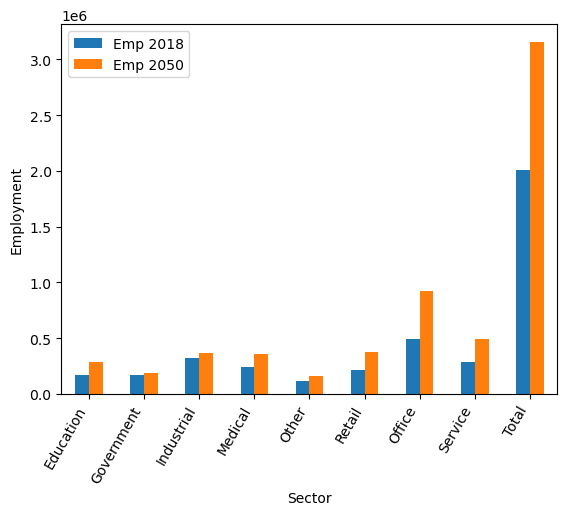

In [22]:
# producing regional summary comparison by sector
psrc_emp_sum = psrc_emp_to_compare.sum(axis = 0)
psrc_emp_sum = psrc_emp_sum.to_frame()
psrc_emp_sum = psrc_emp_sum.reset_index()
psrc_emp_sum.columns = ['Sector', 'Emp 2018']

psrc_emp_sum_2050 = psrc_emp_to_compare_2050.sum(axis = 0)
psrc_emp_sum_2050 = psrc_emp_sum_2050.to_frame()
psrc_emp_sum_2050 = psrc_emp_sum_2050.reset_index()
psrc_emp_sum_2050.columns = ['Sector', 'Emp 2050']
psrc_emp_sum_compare = pd.merge(psrc_emp_sum,
                                psrc_emp_sum_2050, 
                                on = 'Sector', how = 'left')
psrc_emp_sum_compare.loc[:, 'Sector'] = \
psrc_emp_sum_compare.loc[:, 'Sector'].str.split('_').str[1]
psrc_emp_sum_compare = psrc_emp_sum_compare.set_index('Sector')
psrc_emp_sum_compare.plot.bar()
plt.xticks(rotation = 60, ha = 'right')
plt.ylabel('Employment')
plt.savefig('plot/Total_emp_comparison_2018_2050.png', dpi = 300, bbox_inches = 'tight')
plt.show()
psrc_emp_sum_compare.to_csv('SoundCast_processed/emp_forecast_summary.csv')

2645
2064805.0 2009687
Education
623.6 -0.15
Government
362.0 -0.96
Industrial
796.7 0.37
Medical
384.5 0.31
Other
24.5 0.98
Retail
767.7 0.23
Office
735.6 0.73
Service
104.8 0.91
Total
1630.4 0.68


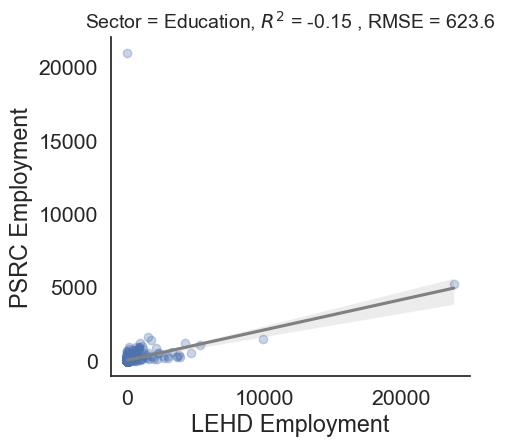

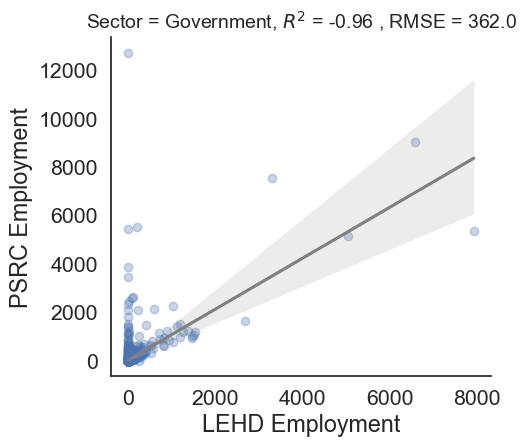

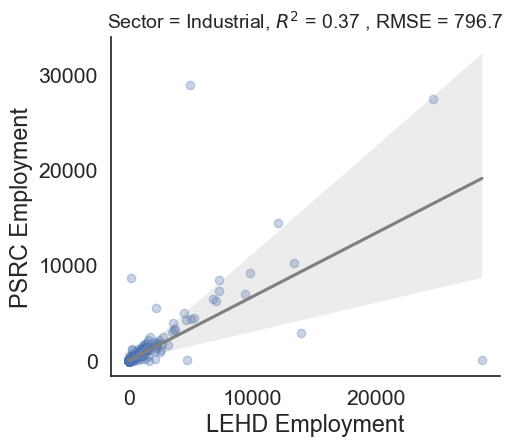

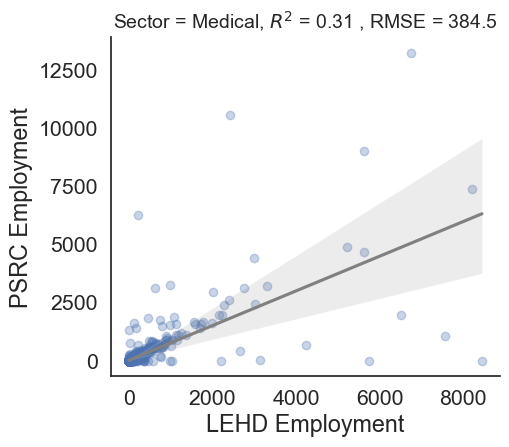

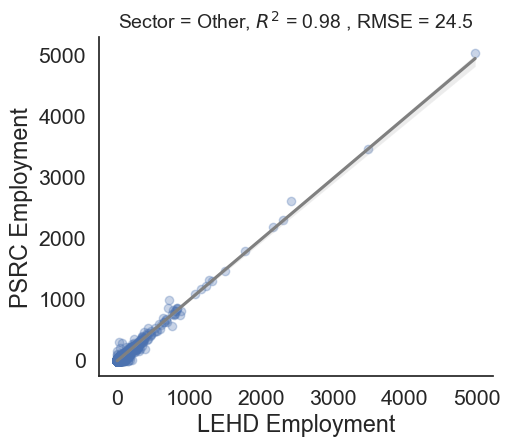

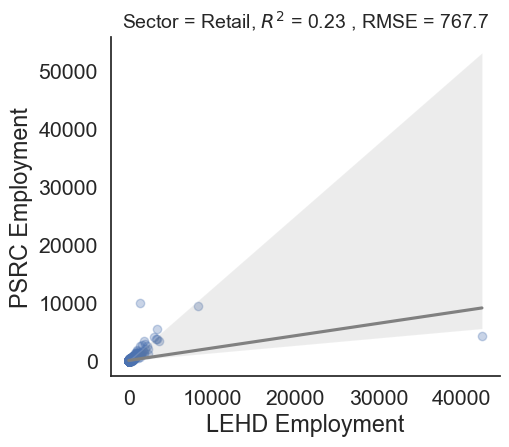

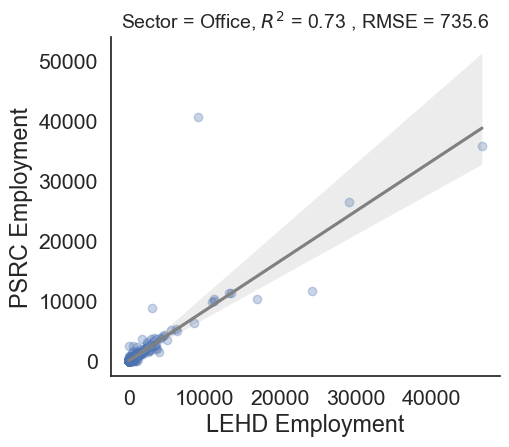

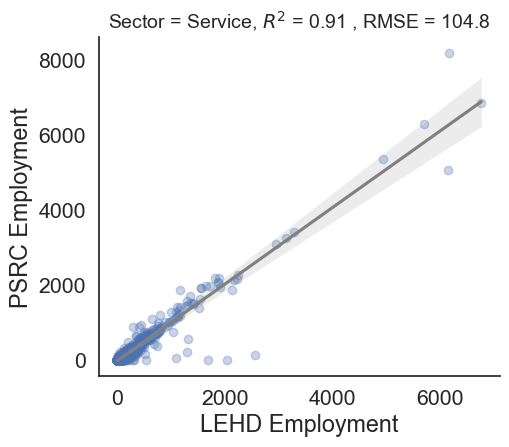

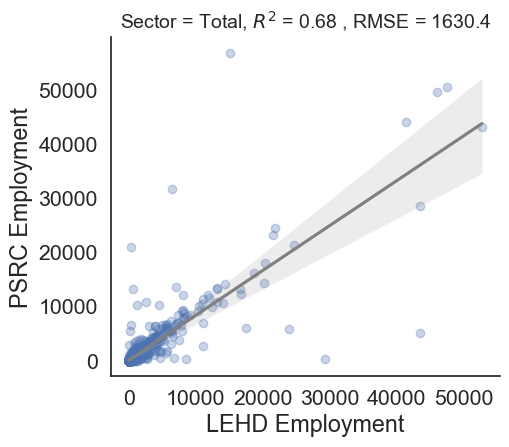

In [23]:
# compare employment from PSRC and LEHD
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import numpy as np

emp_to_compare = pd.merge(psrc_emp_to_compare, lehd_validation, 
                          left_index = True, right_index = True, how = 'left')

print(len(emp_to_compare))

joint_sector = ['Education', 'Government', 'Industrial', 'Medical',
              'Other', 'Retail', 'Office', 'Service', 'Total']
emp_to_compare.fillna(0, inplace = True)
print(emp_to_compare.LEHD_Total.sum(), emp_to_compare.PSRC_Total.sum())
emp_to_compare.head(5)

for sec in joint_sector:
    print(sec)
    lehd_attr = 'LEHD_' + sec
    psrc_attr = 'PSRC_' + sec

    rmse_emp = mean_squared_error(emp_to_compare[lehd_attr], 
                                  emp_to_compare[psrc_attr], squared = False)
    r2_emp = r2_score(emp_to_compare[lehd_attr], 
                      emp_to_compare[psrc_attr])
    rmse_emp = np.round(rmse_emp, 1)
    r2_emp = np.round(r2_emp, 2)
    print(rmse_emp, r2_emp)
    plt.style.use('seaborn-v0_8-white')
    # plt.rcParams['axes.facecolor'] = 'white'
    sns.set(font_scale=1.4)  # crazy big
    sns.set_style("white")
    sns.lmplot(
        data=emp_to_compare,
        x=lehd_attr, y=psrc_attr, 
        height=4.5, aspect = 1.2, line_kws={'color': 'grey'}, 
        scatter_kws = {'alpha':0.3})
    # g.set_facecolor("white")
    
    # plt.xlim([0, 1300000])
    # plt.ylim([0, 1300000])
    plt.xlabel('LEHD Employment')
    plt.ylabel('PSRC Employment')
    plt.title('Sector = ' + sec + ', $R^{2}$ = ' + str(r2_emp) + \
              ' , RMSE = ' + str(rmse_emp), fontsize = 14)
    plt.savefig('plot/emp_by_cbg_' + sec +'_validation.png', dpi = 200,
               bbox_inches = 'tight')

2645
2009687 3157305
Education
158.3 0.87
Government
322.9 0.49
Industrial
225.8 0.95
Medical
213.8 0.82
Other
73.0 0.84
Retail
335.8 0.26
Office
1064.0 0.39
Service
301.0 0.36
Total
1715.1 0.64


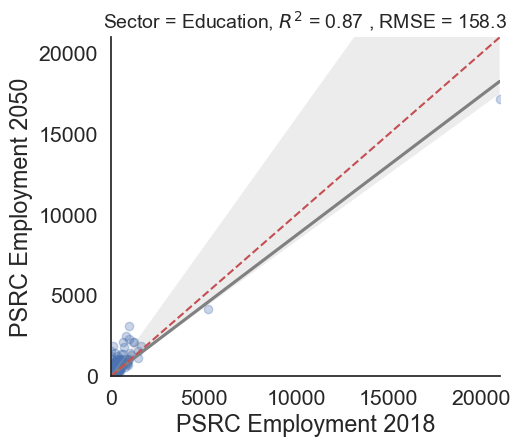

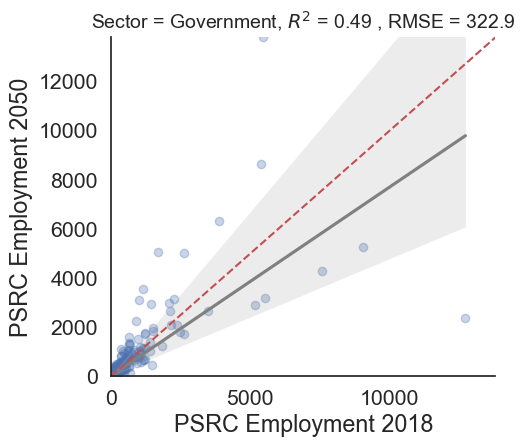

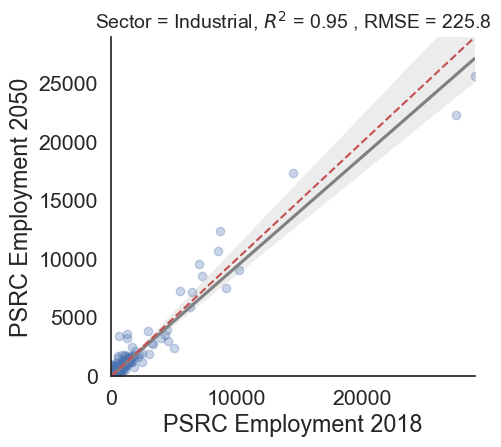

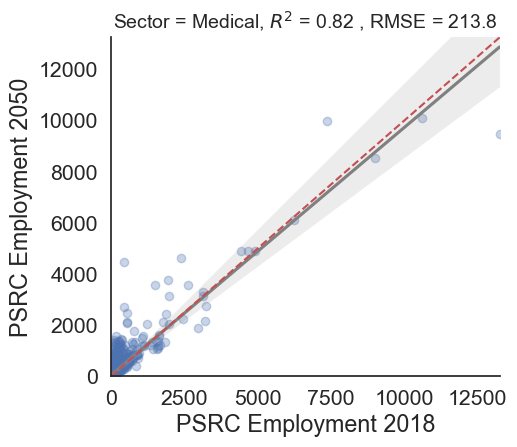

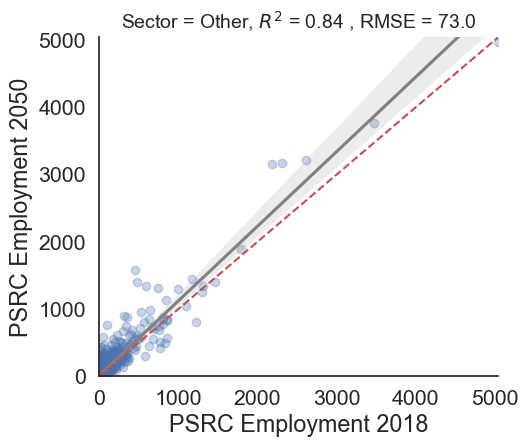

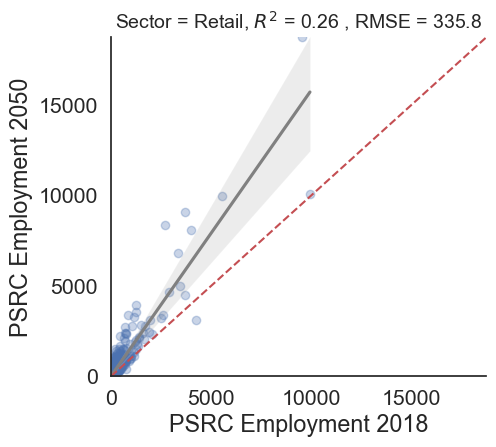

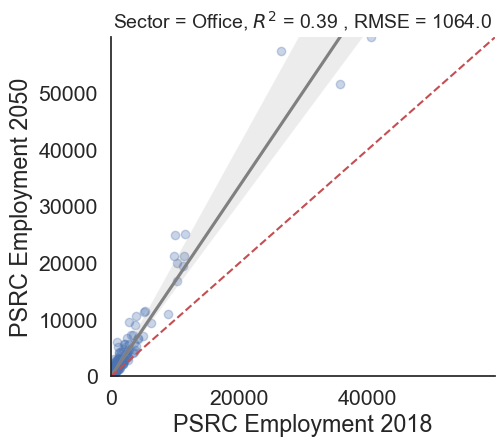

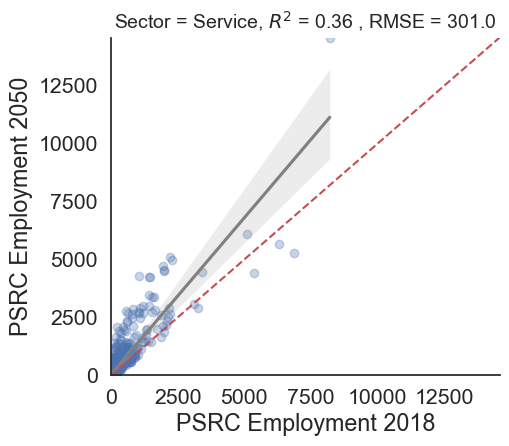

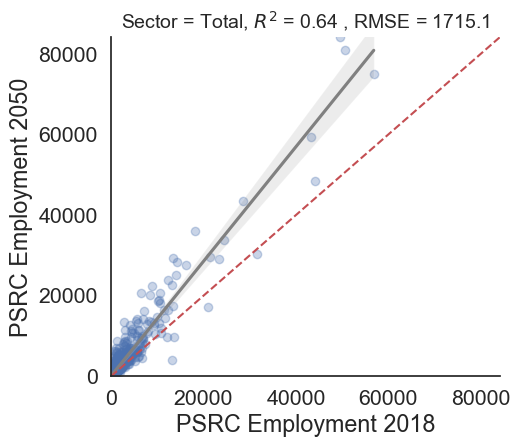

In [18]:
# compare base and future year soundcast data
emp_to_compare_forecast = pd.merge(psrc_emp_to_compare, 
                                   psrc_emp_to_compare_2050, 
                          left_index = True, right_index = True, how = 'left')

print(len(emp_to_compare_forecast))

joint_sector = ['Education', 'Government', 'Industrial', 'Medical',
              'Other', 'Retail', 'Office', 'Service', 'Total']
emp_to_compare_forecast.fillna(0, inplace = True)
print(emp_to_compare_forecast.PSRC_Total_x.sum(), 
      emp_to_compare_forecast.PSRC_Total_y.sum())
emp_to_compare_forecast.head(5)

for sec in joint_sector:
    print(sec)
    base_attr = 'PSRC_' + sec + '_x'
    future_attr = 'PSRC_' + sec + '_y'

    rmse_emp = mean_squared_error(emp_to_compare_forecast[base_attr], 
                                  emp_to_compare_forecast[future_attr], 
                                  squared = False)
    r2_emp = r2_score(emp_to_compare_forecast[base_attr], 
                      emp_to_compare_forecast[future_attr])
    
    rmse_emp = np.round(rmse_emp, 1)
    r2_emp = np.round(r2_emp, 2)
    print(rmse_emp, r2_emp)
    plt.style.use('seaborn-v0_8-white')
    max_value = max(emp_to_compare_forecast[base_attr].max(), 
                      emp_to_compare_forecast[future_attr].max())
    # plt.rcParams['axes.facecolor'] = 'white'
    sns.set(font_scale=1.4)  # crazy big
    sns.set_style("white")
    ax = sns.lmplot(
        data=emp_to_compare_forecast,
        x=base_attr, y=future_attr, 
        height=4.5, aspect = 1.2, line_kws={'color': 'grey'}, 
        scatter_kws = {'alpha':0.3})
    # g.set_facecolor("white")
    plt.plot([0, max_value], [0, max_value], 'r--', label='y=x')
    plt.xlim([0, max_value])
    plt.ylim([0, max_value])
    plt.xlabel('PSRC Employment 2018')
    plt.ylabel('PSRC Employment 2050')
    plt.title('Sector = ' + sec + ', $R^{2}$ = ' + str(r2_emp) + \
              ' , RMSE = ' + str(rmse_emp), fontsize = 14)
    plt.savefig('plot/forecast_emp_by_cbg_' + sec +'.png', dpi = 200,
               bbox_inches = 'tight')

In [20]:
# adding SynthFirm
emp_to_compare = emp_to_compare.reset_index()
synthfirm_emp_df = synthfirm_emp_df.reset_index()
synthfirm_emp_df['GEOID'] = synthfirm_emp_df['GEOID'].astype(int)
emp_to_compare_add_synthfirm = pd.merge(emp_to_compare, synthfirm_emp_df, 
                          on = 'GEOID', how = 'left')
emp_to_compare_add_synthfirm.head(5)

index_x         GEOID  PSRC_Education  PSRC_Government  PSRC_Industrial  \
0        0  530330001001               0                0                0   
1        1  530330001002               7                0              105   
2        2  530330001003              43                4               13   
3        3  530330001004               4                1               24   
4        4  530330001005               9                0               54   

   PSRC_Medical  PSRC_Other  PSRC_Retail  PSRC_Office  PSRC_Service  ...  \
0             0           0            0            0             0  ...   
1            22          18           44          155            42  ...   
2            27          10          370           39            86  ...   
3             8           7           11           16            28  ...   
4            27          72          360           76           178  ...   

   index_y  SynthFirm_Other  SynthFirm_Industrial  SynthFirm_Retail  \
0    998.0        43.514704              0.000000          0.000000   
1    989.0         3.277003            420.354459        187.360855   
2   1048.0        19.757850              0.000000         93.134110   
3   1115.0        18.187941              0.000000         29.167997   
4    263.0        70.465266            131.424117        151.581577   

   SynthFirm_Office  SynthFirm_Education  SynthFirm_Medical  \
0        946.727641             0.000000           0.000000   
1        363.132550           140.994273         107.649067   
2         62.440079             5.898866          74.428381   
3          4.766572             0.000000           3.132178   
4        196.720878            52.202280         120.956594   

   SynthFirm_Service  SynthFirm_Government  SynthFirm_Total  
0           0.000000                   0.0       990.242345  
1         173.534899                   0.0      1396.303107  
2         299.728801                   0.0       555.388087  
3          44.897564                   0.0       100.152253  
4         250.157605                   0.0       973.508316  

[5 rows x 30 columns]

In [22]:
emp_to_compare_add_synthfirm.to_csv('SoundCast_processed/parcel_employment_by_cbg_comparison.csv')

In [23]:
# produce summary statistics
emp_to_compare_sums = pd.DataFrame(emp_to_compare_add_synthfirm.sum())
emp_to_compare_sums = emp_to_compare_sums.reset_index()
emp_to_compare_sums.columns = ['Var', 'Employment']
emp_to_compare_sums.loc[:, 'Source'] = \
emp_to_compare_sums.loc[:, 'Var'].str.split('_').str[0]
emp_to_compare_sums.loc[:, 'Sector'] = \
emp_to_compare_sums.loc[:, 'Var'].str.split('_').str[1]
emp_to_compare_sums.to_csv('SoundCast_processed/total_emp_validation_lehd.csv')

In [24]:
# state = '53'
# analysis_year = 2018
# region_cbg_map = block_groups(state = state, year = analysis_year)
# # region_cbg_map.head(5)
# region_cbg_map = region_cbg_map[['GEOID', 'ALAND', 'geometry']]
psrc_emp_by_cbg = psrc_emp_by_cbg.reset_index()
psrc_emp_by_cbg_2050 = psrc_emp_by_cbg_2050.reset_index()

region_cbg_map.loc[:, 'GEOID'] = \
region_cbg_map.loc[:, 'GEOID'].astype(str).str.zfill(12)
psrc_emp_by_cbg.loc[:, 'GEOID'] = \
psrc_emp_by_cbg.loc[:, 'GEOID'].astype(str).str.zfill(12)
psrc_emp_by_cbg_2050.loc[:, 'GEOID'] = \
psrc_emp_by_cbg_2050.loc[:, 'GEOID'].astype(str).str.zfill(12)

region_cbg_map_psrc = region_cbg_map.merge(psrc_emp_by_cbg,
                                      on = 'GEOID',
                                      how = 'inner')
# region_cbg_map_psrc.head(5)

region_cbg_map_psrc_2050 = region_cbg_map.merge(psrc_emp_by_cbg_2050,
                                      on = 'GEOID',
                                      how = 'inner')
region_cbg_map_psrc_2050.head(5)

GEOID    ALAND                                           geometry  \
0  530610518023  1847888  POLYGON ((-122.28188 47.84291, -122.28146 47.8...   
1  530530634006   319199  POLYGON ((-122.44199 47.17191, -122.44197 47.1...   
2  530330219042   367206  POLYGON ((-122.17557 47.72344, -122.17328 47.7...   
3  530330219044   318915  POLYGON ((-122.17558 47.72581, -122.17323 47.7...   
4  530330219051   759979  POLYGON ((-122.18723 47.74653, -122.18719 47.7...   

  CountyName Census2010BlockGroup  BaseYear  empedu_p  empfoo_p  empgov_p  \
0  Snohomish         530610518023      2018       181      2303       258   
1     Pierce         530530634006      2018         3         0         0   
2       King         530330219042      2018         0         0         0   
3       King         530330219044      2018         0         0         0   
4       King         530330219051      2018        62        29         0   

   empind_p  ...  empsvc_p  emptot_p  PSRC_Education  PSRC_Government  \
0       241  ...      1059     16271             181              258   
1        17  ...         6        41               3                0   
2         2  ...        20       227               0                0   
3         0  ...         0         0               0                0   
4        43  ...        35       655              62                0   

   PSRC_Industrial  PSRC_Medical  PSRC_Other  PSRC_Retail  PSRC_Office  \
0              241           664         238         9092         2235   
1               17             1           4            1            9   
2                2           196           1            1            7   
3                0             0           0            0            0   
4               43           408          45           18           15   

   PSRC_Service  
0          3362  
1             6  
2            20  
3             0  
4            64  

[5 rows x 24 columns]

EPSG:4269


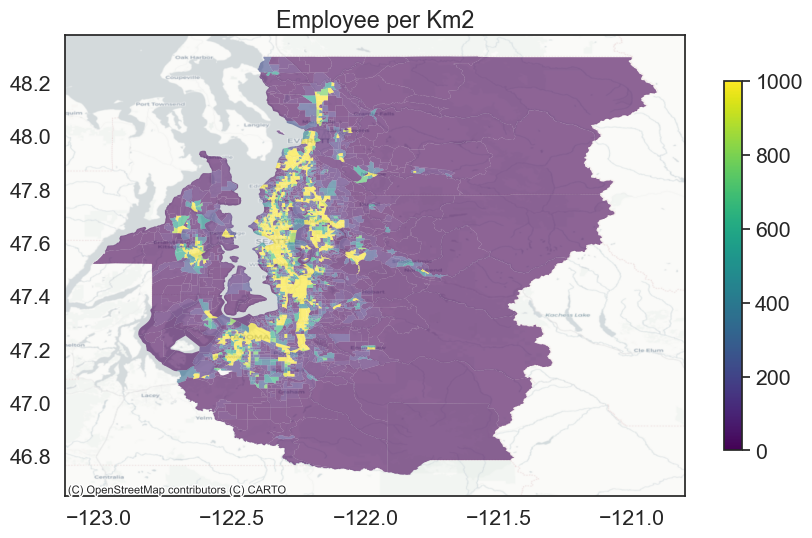

In [26]:
print(region_cbg_map.crs)
# psrc 2050
region_cbg_map_psrc_2050.loc[:, 'emp_per_km2'] = \
region_cbg_map_psrc_2050.loc[:, 'emptot_p'] / region_cbg_map_psrc_2050.loc[:, 'ALAND'] * 10**6
ax = region_cbg_map_psrc_2050.plot(figsize = (10,12), 
                         column = 'emp_per_km2', 
                         cmap='viridis',
                         alpha = 0.6, 
                        vmin = 0, vmax =1000, 
                         linewidth=0.01, legend=True,
                          legend_kwds = {'shrink': 0.4})
plt.title('Employee per Km2')
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron, crs = 'EPSG:4269')
ax.grid(False)
plt.savefig('plot/PSRC_emp_density_2050.png', dpi = 300, bbox_inches = 'tight')

EPSG:4269


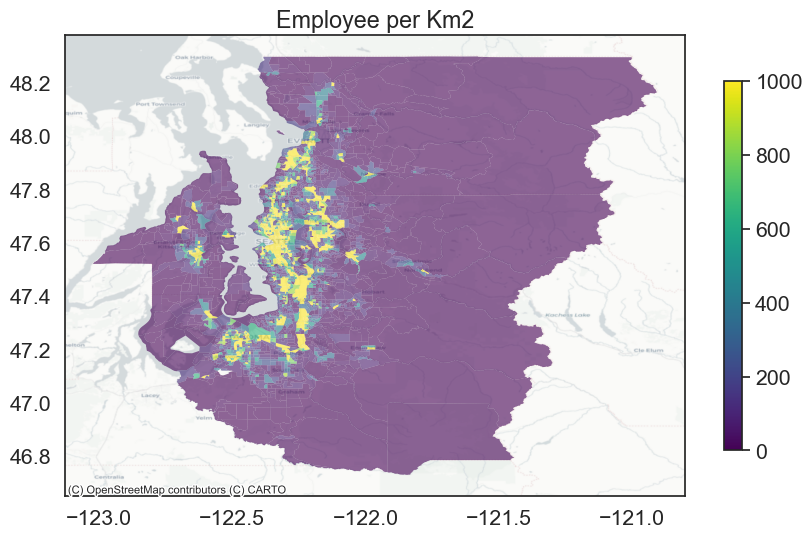

In [27]:
# psrc 2018
print(region_cbg_map.crs)
region_cbg_map_psrc.loc[:, 'emp_per_km2'] = \
region_cbg_map_psrc.loc[:, 'emptot_p'] / region_cbg_map_psrc.loc[:, 'ALAND'] * 10**6
ax = region_cbg_map_psrc.plot(figsize = (10,12), 
                         column = 'emp_per_km2', 
                         cmap='viridis',
                         alpha = 0.6, 
                        vmin = 0, vmax =1000, 
                         linewidth=0.01, legend=True,
                          legend_kwds = {'shrink': 0.4})
plt.title('Employee per Km2')
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron, crs = 'EPSG:4269')
ax.grid(False)
plt.savefig('plot/PSRC_emp_density_2018.png', dpi = 300, bbox_inches = 'tight')

In [38]:
# plot synthfirm firm count
synthfirm_firm_df = synthfirm_firm_df.reset_index()
region_cbg_map_synthfirm = \
region_cbg_map_psrc.merge(synthfirm_firm_df,
                          on = 'GEOID', how = 'left')
print(len(region_cbg_map_synthfirm))
region_cbg_map_synthfirm.head(5)

2645


GEOID    ALAND                                           geometry  \
0  530610518023  1847888  POLYGON ((-122.28188 47.84291, -122.28146 47.8...   
1  530530634006   319199  POLYGON ((-122.44199 47.17191, -122.44197 47.1...   
2  530330219042   367206  POLYGON ((-122.17557 47.72344, -122.17328 47.7...   
3  530330219044   318915  POLYGON ((-122.17558 47.72581, -122.17323 47.7...   
4  530330219051   759979  POLYGON ((-122.18723 47.74653, -122.18719 47.7...   

   EMPLOYEE  emp_per_km2  SynthFirm_Other  SynthFirm_Industrial  \
0      7036  3807.590070              1.0                   5.0   
1        40   125.313676              0.0                   6.0   
2       218   593.672217              0.0                   0.0   
3         0     0.000000              3.0                   3.0   
4       513   675.018652              3.0                   4.0   

   SynthFirm_Retail  SynthFirm_Office  SynthFirm_Education  SynthFirm_Medical  \
0              14.0              39.0                  2.0               12.0   
1               0.0               3.0                  0.0                0.0   
2               0.0              13.0                  0.0               10.0   
3               0.0               4.0                  0.0                1.0   
4               0.0              11.0                  1.0                5.0   

   SynthFirm_Service  SynthFirm_Government  SynthFirm_Total  
0               24.0                   2.0             99.0  
1                0.0                   0.0              9.0  
2               10.0                   0.0             33.0  
3                2.0                   0.0             13.0  
4                6.0                   0.0             30.0

117939.0


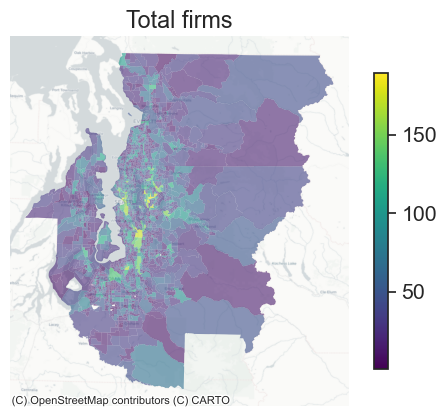

Other


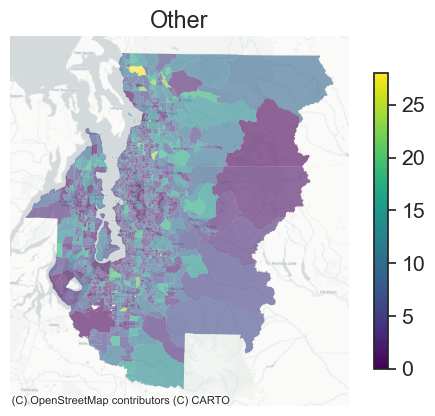

Industrial


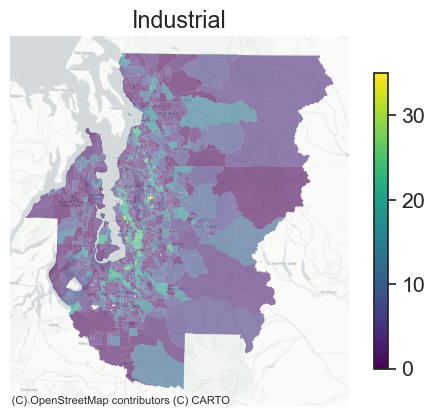

Retail


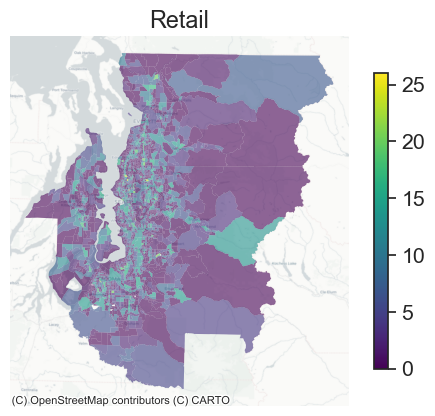

Office


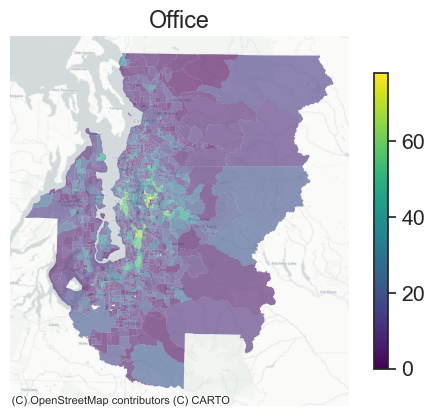

Education


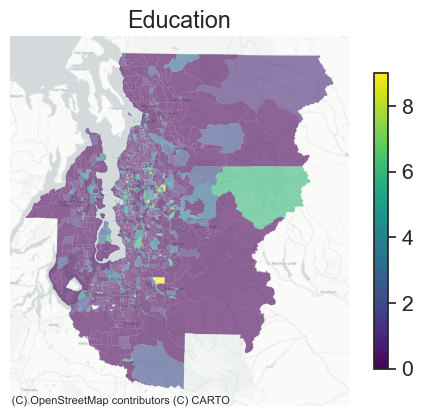

Medical


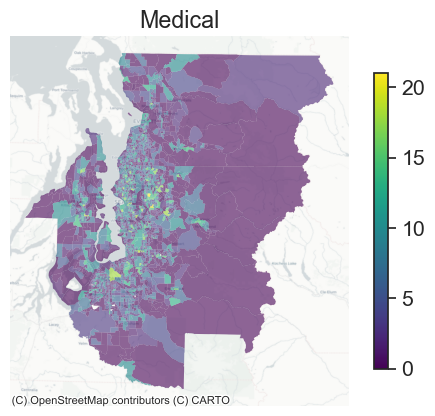

Service


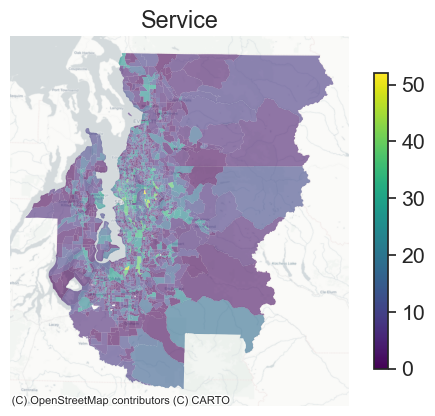

Government


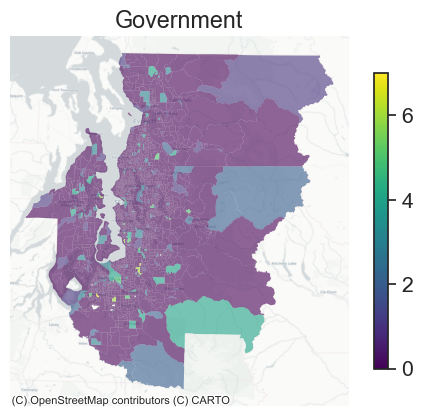

In [45]:
# plot firm distribution
print(region_cbg_map_synthfirm.SynthFirm_Total.sum())
region_cbg_map_synthfirm = region_cbg_map_synthfirm.to_crs(psrc_crs)

ax = region_cbg_map_synthfirm.plot(column = 'SynthFirm_Total',
                               cmap='viridis',
                               alpha = 0.6, 
                               linewidth=0.01, 
                               # markersize = 0.005 * region_cbg_map_synthfirm[ind],
                               # vmin = 0, vmax =1000,
                               legend=True,
                               # norm=matplotlib.colors.LogNorm(vmin=1, 
                               #                                vmax = psrc_parcels_job_only_gdf[ind].max()),
                               legend_kwds = {'shrink': 0.8})
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron, crs = psrc_crs)
plt.title('Total firms')
plt.axis('off')
plt.savefig('plot/cbg_level_firms_from_synthfirm.png', dpi = 300, bbox_inches = 'tight')
plt.show()

for ind in synthfirm_sectors: 
    ind_code = ind.split('_')[1]
    print(ind_code)
    ax = region_cbg_map_synthfirm.plot(column = ind,
                               cmap='viridis',
                               alpha = 0.6, 
                                linewidth=0.01, 
                               # markersize = 0.005 * region_cbg_map_synthfirm[ind],
                               # vmin = 0, vmax =1000,
                               legend=True,
                               # norm=matplotlib.colors.LogNorm(vmin=1, 
                               #                                vmax = psrc_parcels_job_only_gdf[ind].max()),
                               legend_kwds = {'shrink': 0.8})
    cx.add_basemap(ax, source = cx.providers.CartoDB.Positron, crs = psrc_crs)
    plt.title(ind_code)
    plt.axis('off')
    plt.savefig('plot/cbg_level_' + ind_code + '_from_synthfirm.png', dpi = 300, bbox_inches = 'tight')
    plt.show()

In [31]:
# load land use labels
print(psrc_parcels.lutype_p.unique())
land_use_code = pd.read_csv('SoundCast_processed/land_use_code.csv')
land_use_code.head(5)
psrc_parcels = pd.merge(psrc_parcels,
                        land_use_code, 
                        on = 'lutype_p', how = 'left')
print(len(psrc_parcels))
psrc_parcels.head(5)

[22 26 18  3 29 28 20 19 24 25 14  9 13 23 17  8 21 10  7 30  0  2  1 15
  6 12 27  5  4 11]
1302434


aparks  empedu_p  empfoo_p  empgov_p  empind_p  empmed_p  empofc_p  \
0       0         0         0         0         0         0         0   
1       0         0         0         0         0         0         0   
2       0         0         0         0         0         0         0   
3       0         0         0         0         5         2        17   
4       0         0         0         0         0         0         0   

   empoth_p  empret_p  emprsc_p  ...  CountyName   TAZ  BaseYear  \
0         0         0         0  ...        King  1019      2018   
1         0         0         0  ...        King  1018      2018   
2         0         0         0  ...        King  1018      2018   
3         9         6         0  ...        King  1018      2018   
4         0         0         0  ...        King  1018      2018   

        GEOID10  place_name  State  County   FIPS          Definition  \
0  5.303303e+14        Kent     53     033  53033        Right-of-Way   
1  5.303303e+14        Kent     53     033  53033  Vacant Developable   
2  5.303303e+14        Kent     53     033  53033              Office   
3  5.303303e+14        Kent     53     033  53033              Office   
4  5.303303e+14        Kent     53     033  53033  Vacant Developable   

                     LU_Group  
0  Transportation and parking  
1                      Vacant  
2                  Commercial  
3                  Commercial  
4                      Vacant  

[5 rows x 47 columns]

In [32]:
land_use_by_cbg = \
psrc_parcels.groupby(['Census2010BlockGroup', 'LU_Group'])[['sqft_p']].sum()
land_use_by_cbg = land_use_by_cbg.reset_index()
land_use_by_cbg.columns = ['GEOID', 'Land use type', 'area_1000_sqft']
land_use_by_cbg.loc[:, 'GEOID'] = \
land_use_by_cbg.loc[:, 'GEOID'].astype(float).astype(int).astype(str)


In [33]:
land_use_by_cbg = \
land_use_by_cbg.sort_values(by = 'area_1000_sqft', ascending = False)
prime_land_use_by_cbg = land_use_by_cbg.groupby('GEOID').head(1)
prime_land_use_by_cbg = prime_land_use_by_cbg.reset_index()
prime_land_use_by_cbg.head(5)

region_cbg_map = region_cbg_map.merge(prime_land_use_by_cbg,
                                      on = 'GEOID',
                                      how = 'inner')


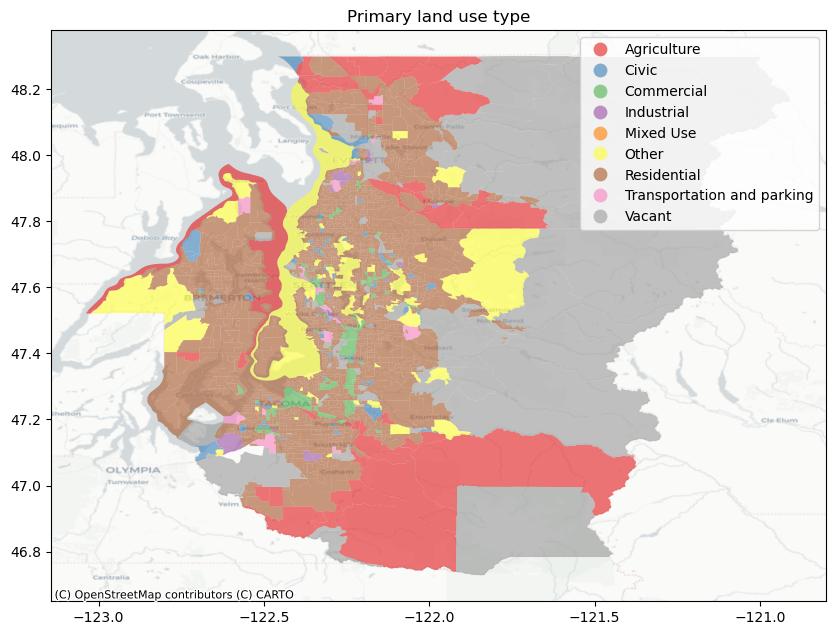

In [34]:
ax = region_cbg_map.plot(figsize = (10,12), 
                         column = 'Land use type', 
                         cmap='Set1',
                         alpha = 0.6, 
                        # vmin = 0, vmax =1000, 
                         linewidth=0.01, legend=True)
plt.title('Primary land use type')
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron, crs = 'EPSG:4269')
ax.grid(False)
plt.savefig('plot/PSRC_primary_lu_type_2018.png', dpi = 300, bbox_inches = 'tight')

In [4]:
db_cur = db_con.cursor()
db_cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(db_cur.fetchall())

[('externals_db',), ('externals_unadjusted',), ('external_trip_distribution',), ('enlisted_personnel',), ('base_year_scaling',), ('parking_zones',), ('psrc_zones',), ('job_trip_rates',), ('auto_externals',), ('group_quarters',), ('trip_rates',), ('special_generators',), ('rate_adjustments',), ('jblm_trips',), ('gravity_model_coefficients',), ('ixxi_mode_share',), ('mode_choice_parameters',), ('time_of_day_factors',), ('heavy_trucks',), ('truck_operating_costs',), ('truck_inputs',), ('seatac',), ('observed_transit_boardings',), ('hourly_counts',), ('acs_commute_mode_by_workplace_geog',), ('acs_commute_mode_home_tract',), ('district_worker_flows',), ('external_nonwork',), ('observed_corridor_speed',), ('light_rail_station_boardings',), ('taz_geography',), ('parcel_2014_geography',), ('running_emission_rates',), ('start_emission_rates',), ('job_attractions',), ('job_productions',), ('truck_time_of_day_factors',), ('daily_counts',), ('observed_external_volumes',), ('observed_screenline_vol

In [12]:
# TRY LOAD PSRC ZONE
psrc_zones_df = pd.read_sql_query("SELECT * FROM psrc_zones", db_con)
psrc_zones_df.head(5)

record  taz county  jblm  external
0       1    1   King     0         0
1       2    2   King     0         0
2       3    3   King     0         0
3       4    4   King     0         0
4       5    5   King     0         0

In [3]:
# LOAD PARCEL
parcel_2018_df = pd.read_sql_query("SELECT * FROM parcel_2018_geography", db_con)
parcel_2018_df.head(5)

field1  ParcelID rg_proposed CityName  Census2010Block  \
0       0         1        Core     Kent     5.303303e+14   
1       1         2        Core     Kent     5.303303e+14   
2       2         3        Core     Kent     5.303303e+14   
3       3         4        Core     Kent     5.303303e+14   
4       4         5        Core     Kent     5.303303e+14   

   Census2010BlockGroup  Census2010Tract  minority_geog  poverty_geog  \
0          5.303303e+11     5.303303e+10              2             1   
1          5.303303e+11     5.303303e+10              2             1   
2          5.303303e+11     5.303303e+10              2             1   
3          5.303303e+11     5.303303e+10              2             1   
4          5.303303e+11     5.303303e+10              2             1   

  GrowthCenterName  ...  elderly_geog_vs_50_percent  \
0         Kent MIC  ...                           0   
1         Kent MIC  ...                           0   
2         Kent MIC  ...                           0   
3         Kent MIC  ...                           0   
4         Kent MIC  ...                           0   

   elderly_geog_vs_reg_total  english_geog_vs_50_percent  \
0                          1                           0   
1                          1                           0   
2                          1                           0   
3                          1                           0   
4                          1                           0   

   english_geog_vs_reg_total poverty_geog_vs_50_percent  \
0                          1                          0   
1                          1                          0   
2                          1                          0   
3                          1                          0   
4                          1                          0   

  poverty_geog_vs_reg_total  racial_geog_vs_50_percent  \
0                         1                          1   
1                         1                          1   
2                         1                          1   
3                         1                          1   
4                         1                          1   

   racial_geog_vs_reg_total  youth_geog_vs_50_percent  youth_geog_vs_reg_total  
0                         1                         0                        0  
1                         1                         0                        0  
2                         1                         0                        0  
3                         1                         0                        0  
4                         1                         0                        0  

[5 rows x 35 columns]

In [11]:
print(parcel_2018_df.columns)
print(parcel_2018_df[['ParcelID', 'place_name', 'FAZID', 'TAZ', 'taz_p', 
                      'parcel_id_x', 'parcel_id_y']].head(10))

Index(['field1', 'ParcelID', 'rg_proposed', 'CityName', 'Census2010Block',
       'Census2010BlockGroup', 'Census2010Tract', 'minority_geog',
       'poverty_geog', 'GrowthCenterName', 'FAZID', 'taz_p', 'parcel_id_x',
       'District', 'district_name', 'CountyName', 'TAZ', 'LowIncome',
       'PeopleofColor', 'BaseYear', 'GEOID10', 'place_name', 'parcel_id_y',
       'disability_geog_vs_50_percent', 'disability_geog_vs_reg_total',
       'elderly_geog_vs_50_percent', 'elderly_geog_vs_reg_total',
       'english_geog_vs_50_percent', 'english_geog_vs_reg_total',
       'poverty_geog_vs_50_percent', 'poverty_geog_vs_reg_total',
       'racial_geog_vs_50_percent', 'racial_geog_vs_reg_total',
       'youth_geog_vs_50_percent', 'youth_geog_vs_reg_total'],
      dtype='object')
   ParcelID place_name  FAZID   TAZ  taz_p  parcel_id_x  parcel_id_y
0         1       Kent   3600  1019   1019            1            1
1         2       Kent   3600  1018   1018            2            2
2         

In [4]:
# write output
parcel_2018_df.to_csv('parcel_2018_geography.csv', index = False)

In [9]:
print(psrc_parcels.columns)

psrc_parcels[['parcelid', 'taz_p']].head(10)

Index(['aparks', 'empedu_p', 'empfoo_p', 'empgov_p', 'empind_p', 'empmed_p',
       'empofc_p', 'empoth_p', 'empret_p', 'emprsc_p', 'empsvc_p', 'emptot_p',
       'hh_p', 'lutype_p', 'mfunits', 'nparks', 'parcelid', 'parkdy_p',
       'parkhr_p', 'ppricdyp', 'pprichrp', 'sfunits', 'sqft_p', 'stugrd_p',
       'stuhgh_p', 'stuuni_p', 'taz_p', 'xcoord_p', 'ycoord_p'],
      dtype='object')


parcelid  taz_p
0         1   1019
1         2   1018
2         3   1018
3         4   1018
4         5   1018
5         6   1018
6         7   1019
7         8   1018
8         9   1018
9        10   1018

In [20]:
truck_volume_df = pd.read_sql_query("SELECT * FROM heavy_trucks", db_con)
print(len(truck_volume_df))
print(truck_volume_df.columns)
truck_volume_df.head(5)
truck_volume_df.to_csv('truck_volume.csv', index = False)

994
Index(['record', 'atri_zone', 'taz', 'year', 'htkpro', 'htkatt'], dtype='object')
